In [ ]:
!git clone https://github.com/daekeun-ml/sm-kornlp-usecases.git 

In [1]:
%cd sm-kornlp-usecases/trocr

C:\Users\82103\[DACON]교원 챌린지\sm-kornlp-usecases\trocr


In [2]:
!pip install -r requirements.txt
!pip install -e .


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Obtaining file:///C:/Users/82103/%5BDACON%5D%EA%B5%90%EC%9B%90%20%EC%B1%8C%EB%A6%B0%EC%A7%80/sm-kornlp-usecases/trocr


ERROR: file:///C:/Users/82103/%5BDACON%5D%EA%B5%90%EC%9B%90%20%EC%B1%8C%EB%A6%B0%EC%A7%80/sm-kornlp-usecases/trocr does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
FULL_TRAINING = True
import random
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pynvml import *
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoTokenizer

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    


In [2]:
if FULL_TRAINING:
    vision_hf_model = 'facebook/deit-base-distilled-patch16-384'
    nlp_hf_model = "klue/roberta-base"
    
    # Reference: https://github.com/huggingface/transformers/issues/15823
    # initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model. 
    # Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(vision_hf_model, nlp_hf_model)
    tokenizer = AutoTokenizer.from_pretrained(nlp_hf_model)
else:
    trocr_model = 'daekeun-ml/ko-trocr-base-nsmc-news-chatbot'
    model = VisionEncoderDecoderModel.from_pretrained(trocr_model)
    tokenizer = AutoTokenizer.from_pretrained(trocr_model)     

Downloading:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

C:\Users\82103\anaconda3\envs\DL\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\82103\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-384 were not used when initializing DeiTModel: ['cls_classifier.weight', 'distillation_classifier.weight', 'cls_classifier.bias', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-384 and are newly initialized: ['deit.pooler.dense.weight', 'deit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.9.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.10.crossattention.self.query.bias', 'roberta.encoder.layer.7.crossattention.output.dense.bias', 'roberta.encoder.layer.11.crossattention.output.dense.bias', 'roberta.encoder.layer.9.crossattention.self.query.weight', 'roberta.encoder.layer.6.crossattention.self.key.bias', 'roberta.encoder.layer.2.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.3.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.4.crossattention.self.value.bias', 'roberta.encoder.layer.4.crossattention.output.dense.bias', 'roberta.encoder.layer.10.crossattention.self.value.weight', 'roberta.encoder

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정


In [51]:
df=pd.read_csv('./data/train.csv')
df.drop(['id'],axis=1,inplace=True)
df.img_path=df.img_path.apply(lambda x: x.lstrip('./'))

In [52]:
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [53]:

df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.1, random_state=CFG['SEED'])

In [47]:
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

71569 5319


In [54]:
train_df=train.drop('len',axis=1)
test_df=val.drop('len',axis=1)

In [55]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [57]:
class OCRDataset(Dataset):
    def __init__(self, dataset_dir, df, processor, tokenizer, max_target_length=32):
        self.dataset_dir = dataset_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['img_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.dataset_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text      
        labels = self.tokenizer(text, padding="max_length", 
                                stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [60]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
dataset_dir = './data/'
max_length = 32

train_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    df=train_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)
eval_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    df=test_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

loading configuration file preprocessor_config.json from cache at C:\Users\82103/.cache\huggingface\hub\models--microsoft--trocr-base-handwritten\snapshots\69659a277424eb381574e4952f3b3fa3440a419b\preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

loading file vocab.json from cache at C:\Users\82103/.cache\huggingface\hub\models--microsoft--trocr-base-handwritt

Number of training examples: 71569
Number of validation examples: 5319


pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


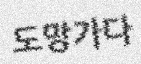

In [62]:
img_idx = np.random.randint(len(train_df))
encoding = train_dataset[img_idx]
for k,v in encoding.items():
    print(k, v.shape)
    
image = Image.open(train_dataset.dataset_dir + train_df['img_path'][img_idx]).convert("RGB")
image    

In [31]:
import os
 
path_dir = './data/train'
 
file_list = os.listdir(path_dir)
print(len(file_list))

76888


In [65]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

도망가다


In [120]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = max_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [127]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    fp16=True,
    learning_rate=4e-5,
    output_dir="./models",
    save_steps=5000,
    eval_steps=5000,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [128]:
import evaluate
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [129]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [130]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

Using cuda_amp half precision backend


In [131]:
import gc
gc.collect()

3226

In [ ]:
result = trainer.train()

***** Running training *****
  Num examples = 71569
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 35785
  Number of trainable parameters = 225701120
Trainer is attempting to log a value of "{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_

Trainer is attempting to log a value of "{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': True, 'cross_attention_hidden_size': None, 'add_cross_attention': True, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'chunk_size_feed_forward': 0, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 's

Step,Training Loss,Validation Loss


In [ ]:
sample_test_df = pd.read_csv('/content/data/test.csv')
sample_test_df.drop(['id'],axis=1,inplace=True)
sample_test_df.img_path=sample_test_df.img_path.apply(lambda x: x.lstrip('./'))

In [ ]:
# 저장된 모델 불러오기
# from transformers import VisionEncoderDecoderModel, AutoTokenizer
# model=VisionEncoderDecoderModel.from_pretrained('./model')
# tokenizer=AutoTokenizer.from_pretrained('./model')

In [ ]:
from tqdm.auto import tqdm
img_names, outputs= [], []
device=torch.device('cuda')
model.to(device)
for i in tqdm(range(len(sample_test_df))):
    image = Image.open(train_dataset.dataset_dir + sample_test_df['img_path'][i]).convert('RGB')
    pixel_values =(processor(image,return_tensors='pt').pixel_values).to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    img_names.append(sample_test_df.img_path[i])
    outputs.append(generated_text) 
    print('Decoded label = {},{}'.format(img_names[i],generated_text))

#img_idx = np.random.randint(len(eval_dataaset))
#image = Image.open(eval_dataset.dataset_dir + train_df['file_name'][img_idx])

In [ ]:
df = pd.DataFrame({'image_names':img_names, 'outputs':outputs})
sub=pd.read_csv('/content/data/sample_submission.csv')
sub['label']=df.outputs
sub.to_csv('trocr_submit.csv',index=False)